In [31]:
from mcculw import ul
from mcculw.enums import InterfaceType
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import ULRange,AnalogInputMode
import time
import numpy as np
from matplotlib import pyplot as plt
import json
import matplotlib.cm as cm
import pandas as pd

In [32]:
AI_name = 'USB-1608G'
AO_name = 'USB-3105'

In [33]:
ul.ignore_instacal()
devices = ul.get_daq_device_inventory(InterfaceType.ANY)

if not devices:
        raise Exception('Error: No DAQ devices found')

for d in devices:
    if d.product_name == AI_name:
        AI = d
    elif d.product_name == AO_name:
        AO = d

In [34]:
in_num = 0
ul.create_daq_device(in_num, AI)

out_num=1
ul.create_daq_device(out_num, AO)

In [35]:
#set ranges

ai_range = ULRange.BIP10VOLTS 
ul.a_input_mode(in_num, AnalogInputMode.SINGLE_ENDED) # SE mode

daq_dev_info = DaqDeviceInfo(out_num)
ao_range = daq_dev_info.get_ao_info().supported_ranges[0]

In [36]:
out_V0_ch = 11
out_Vg1_ch = 5
out_Vg2_ch = 7
in_V0_ch = 7
in_V1_ch = 0
in_V2_ch = 1
in_Vr_ch = 8

edgecomms = pd.DataFrame({'edge':[1,2], 'out_Vg':[out_Vg1_ch, out_Vg2_ch], 'in_dV':[in_V1_ch, in_V2_ch]})

R0 = 3e3 #shunt resistance
GND = 0 #V

gain = 2.

In [37]:
ul.v_out(out_num, out_Vg1_ch, ao_range, 3)
ul.v_out(out_num, out_Vg2_ch, ao_range, 3)
ul.v_out(out_num, out_V0_ch, ao_range, 0)

In [38]:
def V0_scan_updown(V0min=0.1, V0max=5., steps=100, nsamples=10, sleep=0):
    Vrs = []
    dV1s = []
    dV2s = []
    V0s = np.linspace(V0min, V0max, steps)
    V0s_updown = np.concatenate((V0s, V0s[::-1][1:]), axis=-1)
    V0m = []
    
    for V0 in V0s_updown:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        Vr_sublist = []
        V1_sublist = []
        V2_sublist = []
        V0m.append(ul.v_in(in_num, in_V0_ch, ai_range))

        for n in range(nsamples):
            Vrlocal = ul.v_in(in_num, in_Vr_ch, ai_range)
            V1local = ul.v_in(in_num, in_V1_ch, ai_range)
            V2local = ul.v_in(in_num, in_V2_ch, ai_range)
            Vr_sublist.append(Vrlocal)
            V1_sublist.append(V1local)
            V2_sublist.append(V2local)
            time.sleep(1./60./4.)
            if V1local >=10. or V2local >=10:
                print('V1={}, V2={}'.format(V1local, V2local))
                break
        else:
            Vrs.append(np.mean(Vr_sublist))
            dV1s.append(np.mean(V1_sublist))
            dV2s.append(np.mean(V2_sublist))
            time.sleep(sleep)
            continue
        break


    return V0s_updown, dV1s, dV2s, Vrs, V0m

In [39]:
def V0scan_piecewise(V0s =[], nsamples=10, sleep=0):
    Vrs = []
    dV1s = []
    dV2s = []
    V0m = []
    V0s = np.array(V0s)
    
    for V0 in V0s:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        Vr_sublist = []
        V1_sublist = []
        V2_sublist = []
        V0m.append(ul.v_in(in_num, in_V0_ch, ai_range))

        for n in range(nsamples):
            Vrlocal = ul.v_in(in_num, in_Vr_ch, ai_range)
            V1local = ul.v_in(in_num, in_V1_ch, ai_range)
            V2local = ul.v_in(in_num, in_V2_ch, ai_range)
            Vr_sublist.append(Vrlocal)
            V1_sublist.append(V1local)
            V2_sublist.append(V2local)
            time.sleep(1./60./4.)
            if V1local >=10. or V2local >=10:
                print('V1={}, V2={}'.format(V1local, V2local))
                break
        else:
            Vrs.append(np.mean(Vr_sublist))
            dV1s.append(np.mean(V1_sublist))
            dV2s.append(np.mean(V2_sublist))
            time.sleep(sleep)
            continue
        break


    return V0m, dV1s, dV2s, Vrs

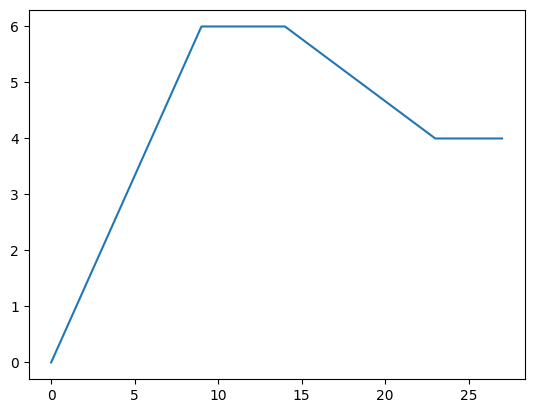

In [88]:
def generate_breakpoints(state = '10', ons = [4., 6.], offs = [4., 0.]):
    #assume 1 turns on first, then 2, etc
    #step 1: go up until you hit the last "1", truncate list
    #step 2: go down until you hit the first "0", truncate list
    #repeat

    breakpoints = [0.]

    localstate = (state+'0')[:-1]

    while localstate:
        laston = localstate.rfind('1')
        if laston == -1:
            break
        breakpoints.append(ons[laston])
        localstate= localstate[:laston]
        firstoff = localstate.find('0')
        if firstoff == -1:
            break
        breakpoints.append(offs[firstoff])
        localstate = localstate[firstoff:]

    return breakpoints

def generate_V0_sequence(breakpoints=[0.], steps=10, hold = 0):
    #steps = # steps between each breakpoint
    #hold = # steps to hold on each breakpoint (constant)
    
    if len(breakpoints) <=1:
        return breakpoints
    else:
        seq = np.array([])
        for previous, current in zip(breakpoints, breakpoints[1:]):
            seq = np.concatenate((seq, np.linspace(previous, current, steps)), axis=-1)
            seq = np.concatenate((seq, np.ones(hold)*current), axis=-1)
        return seq

plt.plot(generate_V0_sequence(generate_breakpoints('01'), hold=4))

In [41]:

V0m, dV1s, dV2s, Vrs = (np.array(x) for x in V0scan_piecewise(V0s = V0seq, sleep=0.1))

# plt.plot(V0m,Vrs)
# plt.plot(V0m, dV1s, label='NDR1')
# plt.plot(V0m, dV2s, label='NDR2')
# plt.legend()
# plt.show()

# # plt.plot(V0s, V0m)

# plt.scatter(dV1s, Vrs)
# plt.scatter(dV2s, Vrs)

In [17]:
def sense_onoff(edge, V0step=0.1, dV_thresh=0.8):
    in_ch =edge.in_dV.values[0]
    current_V0 = 0.
    ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
    
    current_dV = ul.v_in(in_num, in_ch, ai_range)
    switched = False
    while not(switched):
        current_V0 += V0step
        ul.v_out(out_num, out_V0_ch, ao_range, current_V0)

        new_dV = ul.v_in(in_num, in_ch, ai_range)
        if np.abs(new_dV - current_dV) > dV_thresh:
            switched = True
        current_dV = new_dV
    ul.v_out(out_num, out_V0_ch, ao_range, 0.)
    return current_dV

testedge = edgecomms[edgecomms.edge==1]

sense_onoff(testedge)

1.54815673828125

In [28]:
state = '1010'

state[:2]

'_'*5

'_____'

In [117]:
def generate_V0seq_iterative2(state = '10', V0step = 0.1, dV_thresh = 0.8, sleep=0, edgecomms = edgecomms):
    #assume 1 turns on first, then 2, etc
    #step 1: get index of last "1" in sequence. find voltage that switches the edge of that index on. set everything after to nan
    # step 2: get index of first "0" in sequence. find voltage that switches edge of that index off. set everything before to nan

    #check that state length == number of edges
    if len(state) != len(edgecomms):
        raise Exception('State length does not match number of edges')
        return None
    Nedges = len(state)

    
    breakpoints = [0.]
    current_V0 = 0.
    ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
    
    localstate = (state+'0')[:-1]

    while (('1' in localstate) or ('0' in localstate)):
        laston = localstate.rfind('1')
        if laston == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == laston +1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            current_dV = ul.v_in(in_num, in_ch, ai_range)
            while not(switched):
                current_V0 += V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                new_dV = ul.v_in(in_num, in_ch, ai_range)
                if new_dV - current_dV >= dV_thresh:
                    switched = True
                current_dV = new_dV
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:laston] + '_'*(Nedges - laston)
        firstoff = localstate.find('0')
        if firstoff == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == firstoff + 1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            current_dV = ul.v_in(in_num, in_ch, ai_range)
            while not(switched):
                current_V0 -= V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                new_dV = ul.v_in(in_num, in_ch, ai_range)
                if current_dV - new_dV >= dV_thresh:
                    switched = True
                current_dV = new_dV
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = '_'*(firstoff) + localstate[firstoff:]
    ul.v_out(out_num, out_V0_ch, ao_range, 0.)
    return generate_V0_sequence(breakpoints)

In [137]:
def generate_V0seq_iterative(state = '10', V0step = 0.1, dV_thresh = 1.2, sleep=0, edgecomms = edgecomms):
    #assume 1 turns on first, then 2, etc
    #step 1: get index of last "1" in sequence. find voltage that switches the edge of that index on. set everything after to nan
    # step 2: get index of first "0" in sequence. find voltage that switches edge of that index off. set everything before to nan

    #check that state length == number of edges
    if len(state) != len(edgecomms):
        raise Exception('State length does not match number of edges')
        return None
    Nedges = len(state)

    
    breakpoints = [0.]
    current_V0 = 0.
    ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
    
    localstate = (state+'0')[:-1]

    while ((('1' in localstate) or ('0' in localstate)) and current_V0 < 10.):
        laston = localstate.rfind('1')
        if laston == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == laston +1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 += V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                current_dV = ul.v_in(in_num, in_ch, ai_range)
                if current_dV >= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:laston] + '_'*(Nedges - laston)
        firstoff = localstate.find('0')
        if firstoff == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == firstoff + 1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 -= V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                current_dV = ul.v_in(in_num, in_ch, ai_range)
                if current_dV <= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = '_'*(firstoff) + localstate[firstoff:]
    ul.v_out(out_num, out_V0_ch, ao_range, 0.)
    return generate_V0_sequence(breakpoints)

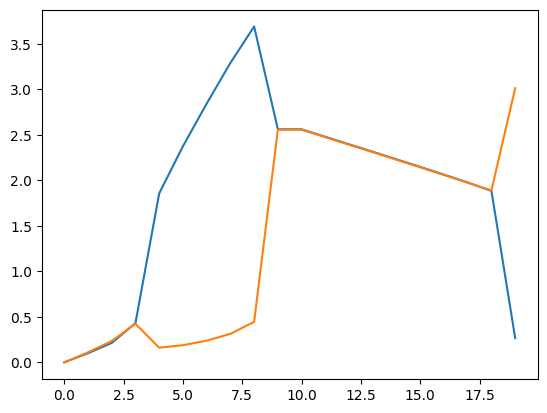

In [139]:
V0seq = generate_V0seq_iterative('01', sleep=0)

V0, V1, V2, Vr = V0scan_piecewise(V0seq)
# ul.v_out(out_num, out_V0_ch, ao_range, 0.)


plt.plot(V1)
plt.plot(V2)


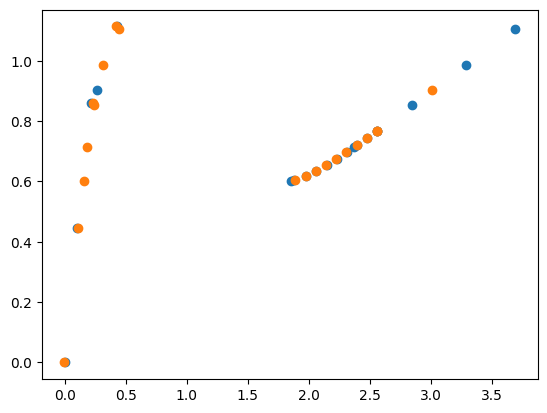

In [140]:
plt.scatter(V1, Vr)
plt.scatter(V2, Vr)

In [141]:
ul.v_out(out_num, out_V0_ch, ao_range, 00.)

In [ ]:
fig, ax = plt.subplots()
ax.plot(dV1s)
ax.plot(dV2s)
# ax.set_xticklabels([round(x,2) for x in V0m[::20]])

In [ ]:
V0m[::20]

In [ ]:
df = pd.DataFrame({'V0':list(V0s), 'V1':list(V1s), 'Vr':list(Vrs), 'R0':R0, 'Vg1': 3, 'Vg2':3, 
                   'RL1':10e3, 'RL2':10e3, 'C1': 20e-6, 'C2': 20e-6, 
                   'CA0': 20e-6, 'CA1': 20e-6, 'CA2': 20e-6, 'sleep':0.1})

df

In [ ]:
df.to_csv('2_NDR_data/equal_with_CAs_slow.csv')

In [ ]:
jsondict = {'V0':list(V0s), 'V1':list(V1s), 'Vr':list(Vrs), 'R0':R0, 'Vg1': 3, 'Vg2':3, 
                   'RL1':10e3, 'RL2':10e3, 'C1': 0, 'C2': 0,  'sleeptime': 1}

with open('./2_NDR_data/equal_nocaps.json', 'w') as f:
    json.dump(jsondict, f)

In [142]:
ul.release_daq_device(in_num)
ul.release_daq_device(out_num)

In [ ]:
outdict